# 📊 Telegram Sentiment Analysis

Simple and powerful sentiment analysis with beautiful visualizations.

In [2]:
# =============================================================================
# CELL 1: Setup and Imports
# =============================================================================

import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from btc_sentiment.pipelines.ingest_pipeline import run_simple_analysis
from btc_sentiment.utils.analysis import load_and_prepare_data, calculate_sentiment_metrics, generate_insights
from btc_sentiment.utils.visualizations import create_sentiment_dashboard, plot_sentiment_with_price
from btc_sentiment.utils.io import load_daily_sentiment, save_dataframe
from btc_sentiment.adapters.binance_price_adapter import BinancePriceAdapter
from btc_sentiment.config.config import get_settings

# Modern clean styling
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

COLORS = {
    'primary':   '#2E86C1',
    'secondary': '#F39C12',
    'positive':  '#27AE60',
    'negative':  '#E74C3C',
    'neutral':   '#95A5A6',
    'accent':    '#8E44AD',
    'bg':        '#F8F9FA'
}

plt.rcParams.update({
    'figure.figsize': (15, 10),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white'
})

sns.set_palette([COLORS['primary'], COLORS['secondary'], COLORS['positive'],
                 COLORS['negative'], COLORS['accent'], COLORS['neutral']])

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 200
pd.options.display.width = 0

print("🎨 Visualization setup complete.")
%matplotlib inline


🎨 Visualization setup complete.


## 🚀 Run Analysis

Choose your analysis period and run sentiment analysis.

🎯 Running sentiment analysis for last 60 days...


Data incomplete for CryptoWorldNews: earliest fetched 2025-07-16T06:55:22+00:00 is later than requested start 2025-07-16T00:00:00+00:00.


📅 Requested window: 2025-07-16 → 2025-09-13 (60 days expected) • telegram rows: 60
Saved 60 records to data/processed/daily_sentiment_20250913_113150.parquet


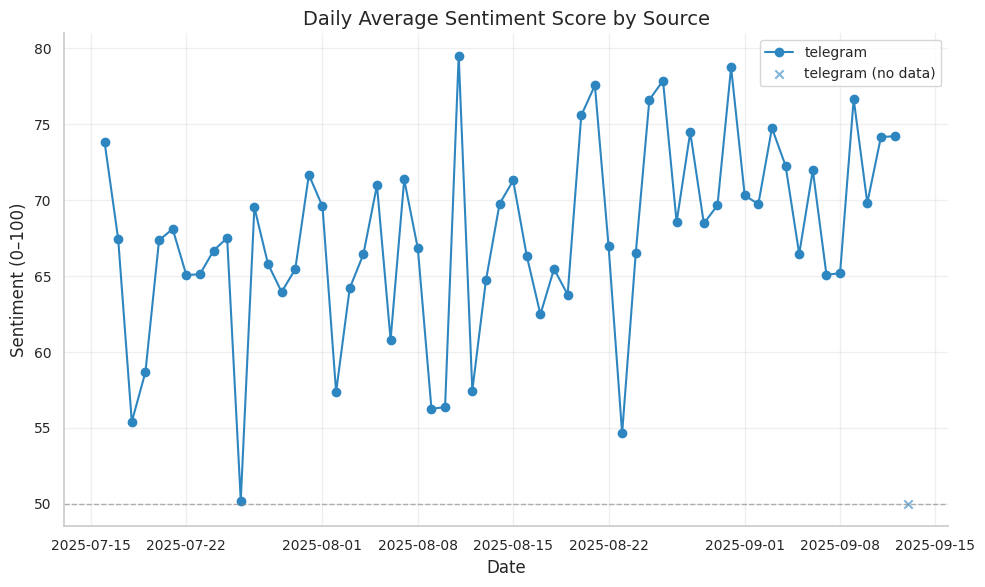

✅ Analysis complete! 60 daily records generated.
✅ Loaded 60 daily rows
📅 Period: 2025-07-16 → 2025-09-13
💬 Total messages: 688
🧭 Coverage: 59 day(s) with data, 1 day(s) with no data


,date,source,avg_score,count,label
0,2025-07-16,telegram,73.841471,17,positive
1,2025-07-17,telegram,67.450000,6,positive
2,2025-07-18,telegram,55.403000,10,neutral
3,2025-07-19,telegram,58.677857,7,positive
4,2025-07-20,telegram,67.358889,9,positive
5,2025-07-21,telegram,68.110000,14,positive
6,2025-07-22,telegram,65.081364,11,positive
7,2025-07-23,telegram,65.116667,15,positive
8,2025-07-24,telegram,66.679643,14,positive
9,2025-07-25,telegram,67.519375,8,positive


In [3]:
import nest_asyncio
nest_asyncio.apply()

DAYS_BACK = 60
INCLUDE_TODAY = True

print(f'🎯 Running sentiment analysis for last {DAYS_BACK} days...')

# Run the analysis (new or old signature)
try:
    daily_records = run_simple_analysis(days_back=DAYS_BACK, include_today=INCLUDE_TODAY, page_size=200)
except TypeError:
    daily_records = run_simple_analysis(days_back=DAYS_BACK, include_today=INCLUDE_TODAY)

# Load results into DataFrame
df = load_and_prepare_data()

if df.empty:
    print('❌ No data available')
    print('💡 Check your Telegram credentials and group access')
else:
    real_days  = int((df["count"] > 0).sum())
    empty_days = int((df["count"] == 0).sum())
    print(f'✅ Loaded {len(df)} daily rows')
    print(f'📅 Period: {df["date"].min().strftime("%Y-%m-%d")} → {df["date"].max().strftime("%Y-%m-%d")}')
    print(f'💬 Total messages: {int(df["count"].sum()):,}')
    print(f'🧭 Coverage: {real_days} day(s) with data, {empty_days} day(s) with no data')
    display(df.head(12))


📓 Cell 3 — Core Sentiment Dashboard (DRY via utils)

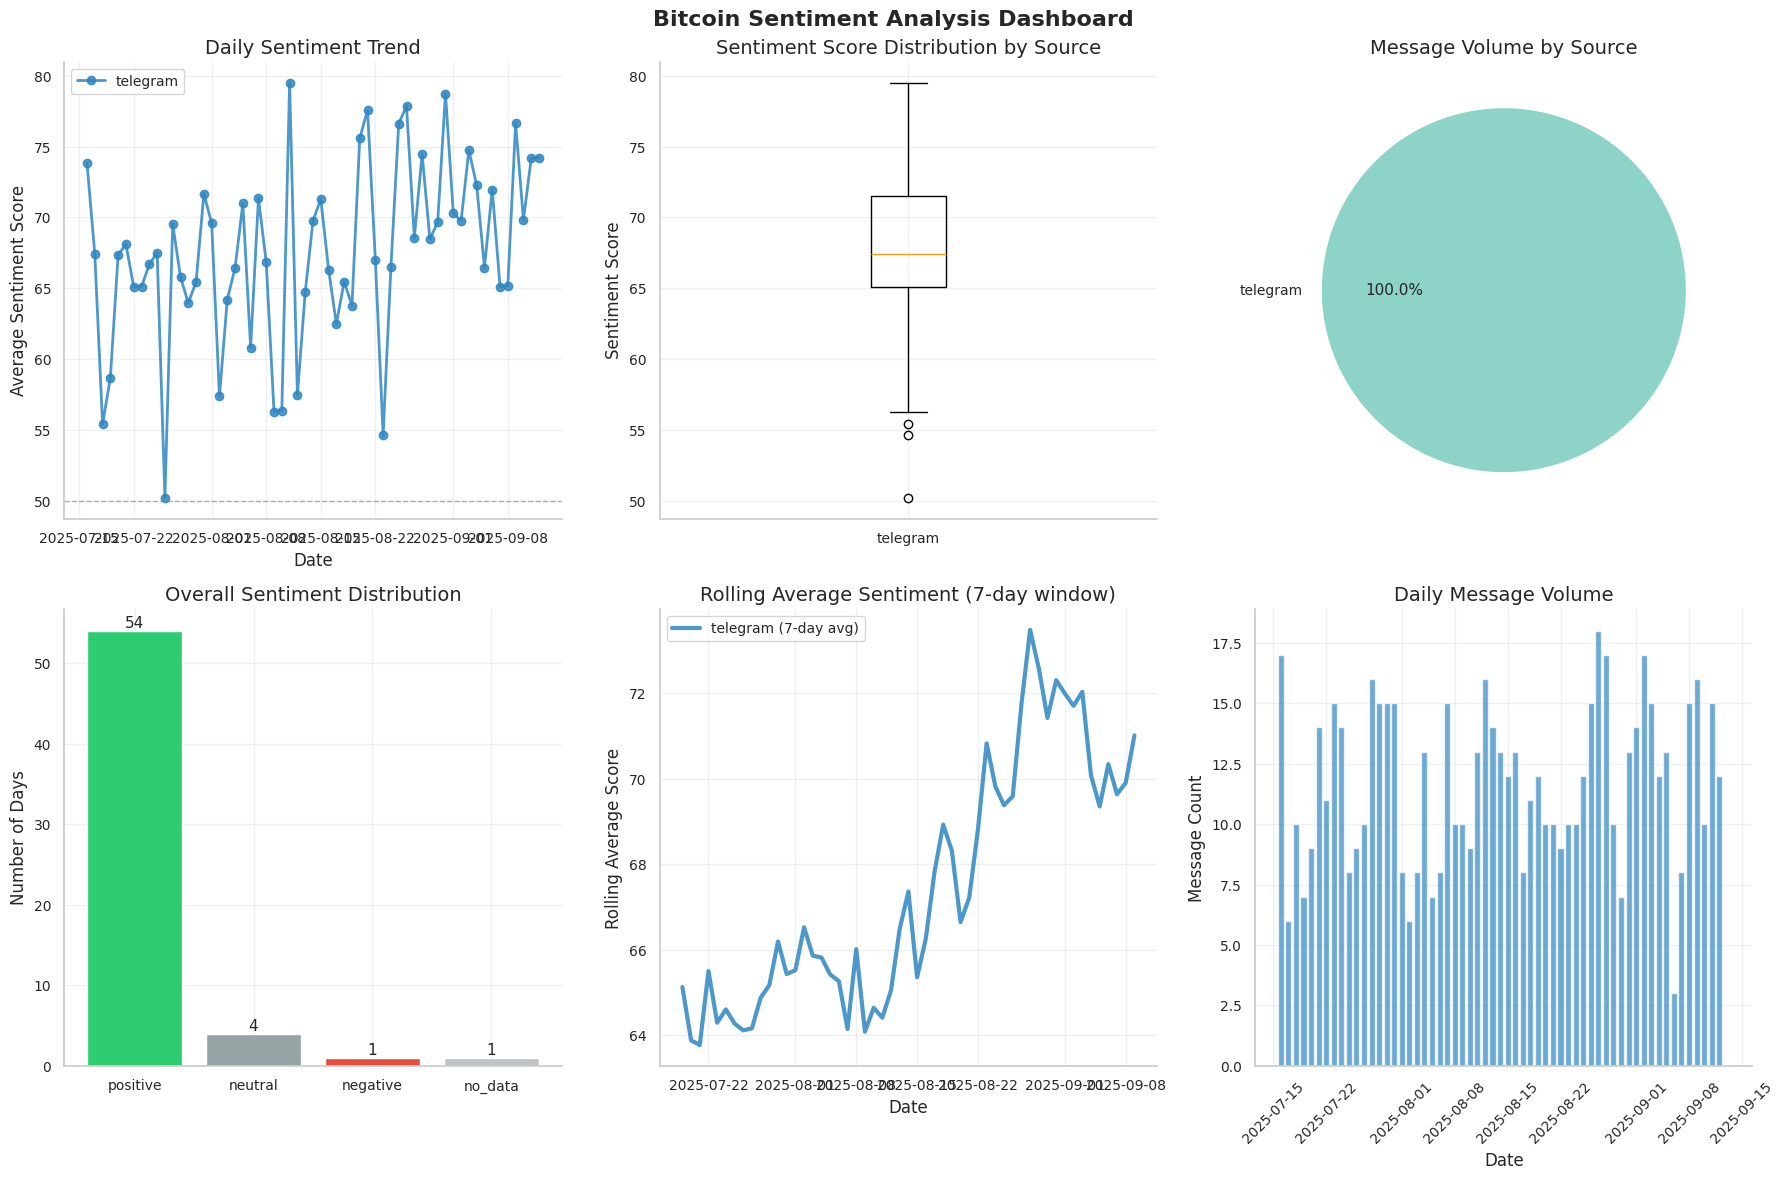

In [4]:
if not df.empty:
    from btc_sentiment.utils.io import load_daily_sentiment
    records = load_daily_sentiment()
    create_sentiment_dashboard(records)


## 📈 Beautiful Sentiment Dashboard

In [5]:
if not df.empty:
    from itertools import groupby
    import numpy as np

    d = df.sort_values('date').copy()
    print('🎯 KEY INSIGHTS')
    print('=' * 60)

    # computed metrics (ignores synthetic no-data rows for score stats)
    metrics = calculate_sentiment_metrics(d)
    if not metrics:
        print("No metrics available.")
    else:
        overall = metrics['overall_sentiment']
        q25, q50, q75 = d.loc[d['count']>0, 'avg_score'].quantile([0.25, 0.5, 0.75]).round(2)

        print(f'📈 Average Sentiment: {overall["mean_score"]:.2f}/100 (median {q50:.2f}; IQR {q25:.2f}–{q75:.2f})')
        if overall["mean_score"] > 55:
            print('   🟢 BULLISH baseline')
        elif overall["mean_score"] < 45:
            print('   🔴 BEARISH baseline')
        else:
            print('   🟡 NEUTRAL baseline')

        print(f'📊 Volatility (std): {overall["std_score"]:.2f}')
        print(f'💬 Total Messages: {metrics["total_messages"]:,}  •  Daily avg: {metrics["total_messages"]/len(d):.0f}')

        best  = d.loc[d['avg_score'].idxmax()]
        worst = d.loc[d['avg_score'].idxmin()]
        busy  = d.loc[d['count'].idxmax()]
        print(f'🚀 Best Day:  {best["date"].strftime("%Y-%m-%d")}  (score {best["avg_score"]:.1f})')
        print(f'📉 Worst Day: {worst["date"].strftime("%Y-%m-%d")}  (score {worst["avg_score"]:.1f})')
        print(f'🔥 Busiest:   {busy["date"].strftime("%Y-%m-%d")}  ({busy["count"]} msgs)')

        # 14-day slope (pts/day) on tail
        if len(d) >= 5:
            tail = d.tail(min(14, len(d)))
            x = np.arange(len(tail))
            m, _ = np.polyfit(x, tail['avg_score'], 1)
            print(f'\n📉/📈 14-day slope: {m:+.2f} pts/day',
                  '→ 🚀 Trending up' if m > 0.2 else '→ 📉 Trending down' if m < -0.2 else '→ ➡️ Flat')

        # Longest streaks by label
        labels = d['label'].tolist()
        def longest_streak(target):
            return max((sum(1 for _ in grp) for val, grp in groupby(labels) if val == target), default=0)
        print(f'\n🔁 Longest positive streak: {longest_streak("positive")} days')
        print(f'🔁 Longest negative streak: {longest_streak("negative")} days')

        # Volume ↔ sentiment correlation (same-day)
        if d['count'].nunique() > 1:
            corr = d['count'].corr(d['avg_score'])
            print(f'\n🔗 Volume–Sentiment correlation: {corr:.3f}',
                  '→ 📊 Strong' if abs(corr) > 0.5 else '→ 🧩 Mild' if abs(corr) > 0.2 else '→ 🫧 Weak/none')

        # Quick natural-language insights
        for tip in generate_insights(d):
            print('•', tip)


🎯 KEY INSIGHTS
📈 Average Sentiment: 67.62/100 (median 67.45; IQR 65.09–71.52)
   🟢 BULLISH baseline
📊 Volatility (std): 6.41
💬 Total Messages: 688  •  Daily avg: 11
🚀 Best Day:  2025-08-11  (score 79.5)
📉 Worst Day: 2025-09-13  (score 50.0)
🔥 Busiest:   2025-08-27  (18 msgs)

📉/📈 14-day slope: -0.69 pts/day → 📉 Trending down

🔁 Longest positive streak: 28 days
🔁 Longest negative streak: 1 days

🔗 Volume–Sentiment correlation: 0.401 → 🧩 Mild
• 📈 Overall sentiment is positive (avg: 67.6)


## 📊 Key Insights & Statistics

In [6]:
if not df.empty:
    import numpy as np
    from itertools import groupby

    d = df.sort_values('date').copy()

    print('🎯 KEY INSIGHTS')
    print('=' * 60)

    avg = d['avg_score'].mean()
    std = d['avg_score'].std()
    tot_msgs = d['count'].sum()
    q25, q50, q75 = d['avg_score'].quantile([0.25, 0.5, 0.75]).round(2)

    print(f'📈 Average Sentiment: {avg:.2f}/100 (median {q50:.2f}; IQR {q25:.2f}–{q75:.2f})')
    if avg > 55:
        print('   🟢 BULLISH baseline')
    elif avg < 45:
        print('   🔴 BEARISH baseline')
    else:
        print('   🟡 NEUTRAL baseline')

    print(f'📊 Volatility (std): {std:.2f}')
    print(f'💬 Total Messages: {tot_msgs:,}  •  Daily avg: {tot_msgs/len(d):.0f}')

    best = d.loc[d['avg_score'].idxmax()]
    worst = d.loc[d['avg_score'].idxmin()]
    busy = d.loc[d['count'].idxmax()]
    print(f'🚀 Best Day:  {best["date"].strftime("%Y-%m-%d")}  (score {best["avg_score"]:.1f})')
    print(f'📉 Worst Day: {worst["date"].strftime("%Y-%m-%d")}  (score {worst["avg_score"]:.1f})')
    print(f'🔥 Busiest:   {busy["date"].strftime("%Y-%m-%d")}  ({busy["count"]} msgs)')

    # 14-day slope (pts/day)
    if len(d) >= 5:
        tail = d.tail(min(14, len(d)))
        x = np.arange(len(tail))
        m, b = np.polyfit(x, tail['avg_score'], 1)
        print(f'\n📉/📈 14-day slope: {m:+.2f} pts/day')
        if m > 0.2:
            print('   🚀 Trending up')
        elif m < -0.2:
            print('   📉 Trending down')
        else:
            print('   ➡️ Flat')

    # Longest positive/negative streaks by label
    labels = d['label'].tolist()
    def longest_streak(target):
        return max((sum(1 for _ in grp) for val, grp in groupby(labels) if val == target), default=0)
    print(f'\n🔁 Longest positive streak: {longest_streak("positive")} days')
    print(f'🔁 Longest negative streak: {longest_streak("negative")} days')

    # Correlation
    if d['count'].nunique() > 1:
        corr = d['count'].corr(d['avg_score'])
        print(f'\n🔗 Volume–Sentiment correlation: {corr:.3f}')
        if abs(corr) > 0.5:
            print('   📊 Strong relationship')
        elif abs(corr) > 0.2:
            print('   🧩 Mild relationship')
        else:
            print('   🫧 Weak/none')


🎯 KEY INSIGHTS
📈 Average Sentiment: 67.32/100 (median 67.40; IQR 64.99–71.44)
   🟢 BULLISH baseline
📊 Volatility (std): 6.75
💬 Total Messages: 688  •  Daily avg: 11
🚀 Best Day:  2025-08-11  (score 79.5)
📉 Worst Day: 2025-09-13  (score 50.0)
🔥 Busiest:   2025-08-27  (18 msgs)

📉/📈 14-day slope: -0.69 pts/day
   📉 Trending down

🔁 Longest positive streak: 28 days
🔁 Longest negative streak: 1 days

🔗 Volume–Sentiment correlation: 0.401
   🧩 Mild relationship


## 🎨 Advanced Visualizations

In [7]:
if not df.empty:
    import numpy as np

    # normalize dates to daily (naive, midnight) to align with Binance '1d' klines
    d = df.copy()
    d['date'] = pd.to_datetime(d['date'], utc=True, errors='coerce').dt.tz_convert(None).dt.normalize()

    # fetch daily prices for same window
    settings = get_settings()
    symbol = getattr(settings, "BINANCE_SYMBOL", "BTCUSDT")
    start_date, end_date = d['date'].min(), d['date'].max()

    px_adapter = BinancePriceAdapter()
    px = px_adapter.fetch_daily_close(symbol=symbol, start=start_date, end=end_date)

    if px.empty:
        print("⚠️ No price data returned from Binance.")
    else:
        # merge & compute returns
        merged = d.merge(px[['date', 'close']].rename(columns={'close': 'btc_close'}), on='date', how='left')
        merged['btc_ret_pct'] = merged['btc_close'].pct_change() * 100.0

        # correlations (Pearson + Spearman; same-day, and 1-day lead/lag)
        def corr_pair(x, y):
            a = pd.Series(x).astype(float)
            b = pd.Series(y).astype(float)
            if a.notna().sum() < 3 or b.notna().sum() < 3:
                return np.nan, np.nan
            return (a.corr(b, method='pearson'), a.corr(b, method='spearman'))

        pearson_lvl, spearman_lvl = corr_pair(merged['avg_score'], merged['btc_close'])
        pearson_ret, spearman_ret = corr_pair(merged['avg_score'], merged['btc_ret_pct'])

        # lead: does sentiment predict next day's return?
        pearson_lead, spearman_lead = corr_pair(merged['avg_score'], merged['btc_ret_pct'].shift(-1))
        # lag: does price return lead sentiment next day?
        pearson_lag, spearman_lag = corr_pair(merged['avg_score'].shift(-1), merged['btc_ret_pct'])

        # print summary
        print(f"📅 Price window: {merged['date'].min().date()} → {merged['date'].max().date()}")
        print(f"💱 Symbol: {symbol}")
        print("\n🔗 Correlations (Sentiment vs Price):")
        print(f" • Level (same-day):       Pearson {pearson_lvl:.3f} | Spearman {spearman_lvl:.3f}")
        print(f" • Return % (same-day):    Pearson {pearson_ret:.3f} | Spearman {spearman_ret:.3f}")
        print(f" • Lead 1d (predict next): Pearson {pearson_lead:.3f} | Spearman {spearman_lead:.3f}")
        print(f" • Lag  1d (price leads):  Pearson {pearson_lag:.3f} | Spearman {spearman_lag:.3f}")

        # visualize overlay (DRY via utils)
        merged_for_plot = merged.copy()
        merged_for_plot.rename(columns={'btc_close': 'btc_close'}, inplace=True)
        plot_sentiment_with_price(merged_for_plot)

        # save combined dataset (timestamped + stable path)
        save_dataframe(merged, "data/processed/daily_sentiment_with_price.parquet")


ConnectionError: HTTPSConnectionPool(host='api.binance.com', port=443): Max retries exceeded with url: /api/v3/klines?symbol=BTCUSDT&interval=1d&startTime=1752624000000&endTime=1757721600000&limit=1000 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7e266e1c6f50>: Failed to resolve 'api.binance.com' ([Errno -3] Try again)"))